In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt 

In [2]:
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

# Illustrate LHS with Inducing Points

In [3]:
lhs_1 = pd.read_csv('data/lhs_16.csv', index_col=0)
lhs_2 = pd.read_csv('data/lhs_4.csv', index_col=0)

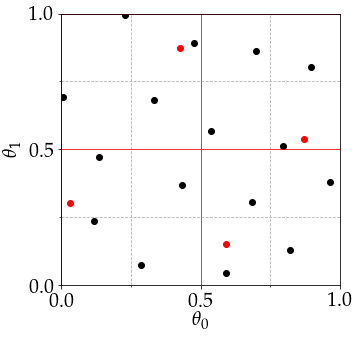

In [39]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(lhs_1['V1'], lhs_1['V2'], marker = 'o', c = 'k')
ax.scatter(lhs_2['V1'], lhs_2['V2'], marker = 'o', c = 'r')
ax.set_yticks(np.linspace(0.0, 1.0, 3), minor=False)
ax.set_yticks(np.linspace(0.0, 1.0, 5), minor=True)
ax.set_xticks(np.linspace(0.0, 1.0, 3), minor=False)
ax.set_xticks(np.linspace(0.0, 1.0, 5), minor=True)
ax.yaxis.grid(True, which='major', linestyle = '-', c = 'r')
ax.yaxis.grid(True, which='minor', linestyle = '--')
ax.xaxis.grid(True, which='major', linestyle = '-', c = 'r')
ax.xaxis.grid(True, which='minor', linestyle = '--')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
plt.ylabel(r'$\theta_{1}$', fontsize = fontSize)
plt.xlabel(r'$\theta_{0}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Testing Sparse GP

In [4]:
import torch
from src.gp.sparseGP import GaussianProcess

In [5]:
inputs = torch.from_numpy(lhs_1.values)
inducing = torch.from_numpy(lhs_2.values)
yvals = torch.sin(inputs[:,0]) * torch.cos(inputs[:,1])

In [11]:
test = GaussianProcess(inputs, yvals, inducing, 1E-5)

In [12]:
params = torch.tensor([-0.2, -0.1, -0.5])

In [13]:
test.cost_function(params)

tensor(-1.0737e-191, dtype=torch.float64)


AssertionError: The determinant term is negative

In [39]:
sigma = torch.tensor(1E-6)
r1 = torch.randn(5, 5)

M = r1 @ r1.t()
Q = torch.randn(10, 5)

In [40]:
R = M + Q.t() @ Q *sigma**-2

In [45]:
torch.logdet(R)

tensor(146.0962)

In [46]:
torch.logdet(R + sigma**-2 * Q.t() @ Q)

tensor(149.5620)

In [47]:
ref = sigma**2 + Q @ torch.linalg.inv(M) @ Q.t()

In [48]:
torch.logdet(ref)

tensor(-72.7282)

In [50]:
10*torch.log(sigma) + 146.0962 - 149.5620

tensor(-141.6209)

In [52]:
torch.logdet(torch.linalg.inv(M))

tensor(-2.9401)

In [53]:
-torch.logdet(M)

tensor(-2.9401)

In [55]:
%%time
torch.logdet(torch.eye(10000))

CPU times: user 8.24 s, sys: 308 ms, total: 8.55 s
Wall time: 1.13 s


tensor(0.)